<a href="https://colab.research.google.com/github/luizfernandoandrade1/sprint-machine-learning-and-analytics/blob/main/MVP_DRAFT_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Atividade desenvolvida para o MVP da disciplina Machine Learning & Analytics.

Contexto do problema a ser resolvido:
Para otimizar a avalaiação de manutenibilidade de projetos de software e sugerir refatorações e melhorias de código, foi utilizado um dataset com métricas para classificar as classes/arquivos com base em suas features para apontar se o arquivo sofreu refatoração ou não. Dessa forma, com base nas métricas dos projetos, prodemos predizer, a partir do treinamento dos modelos, se uma classe precisa ser refatorada.


Instalando tensorFlow para uso no projeto.

In [92]:
!pip install tensorflow scikeras

Carregando as bibliotecas necessárias para o MVP
Dataset utilizado: https://www.kaggle.com/datasets/amalsalilan/code-metrics-dataset-softwareprojectstructure?resource=download

In [85]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, AlphaDropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import Input
from tensorflow.keras.metrics import AUC, Precision, Recall

Carregar DataSet e tratar dados para processamento.

In [86]:
# Carregar o dataset
url = "https://raw.githubusercontent.com/luizfernandoandrade1/sprint-machine-learning-and-analytics/refs/heads/main/OnlyTrivial_dt.csv"
df = pd.read_csv(url)

# Codificar variáveis categóricas
label_encoders = {}
for col in ["file", "class", "type"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Separar features e target
X = df.drop("refactoring", axis=1)
y = df["refactoring"]

# Tratar valores ausentes
X.fillna(X.mean(), inplace=True)


Remoção de colunas irrelevantes para o treinamento do modelo e normalização dos dados

In [87]:

# Remover colunas com baixa variância
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X)
selected_columns = X.columns[selector.get_support(indices=True)]
X = pd.DataFrame(X_var, columns=selected_columns)

# Remover colunas altamente correlacionadas
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print("Colunas dropadas")
print(to_drop)
X.drop(columns=to_drop, inplace=True)

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Colunas dropadas
['fanout', 'lcc', 'staticMethodsQty', 'publicMethodsQty', 'visibleMethodsQty', 'variablesQty']


Divisão dos dados para treino e teste e balanceamento dos dados.

In [88]:
# Seed para reprodutibilidade
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed)


# ⚖️ Calcular pesos das classes
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

Construção e treinamento do modelo

Além do MLP, foram testados alguns algoritmos baseados em arvores, porém o treino se mostrou lento e pouco eficaz, com acurácia menos que 50%.  https://colab.research.google.com/drive/1v8WNon_ntJbSrij_XfSfrOjYFbeb5wgg?usp=sharing

In [89]:
# Construir o modelo MLP com Keras
model = Sequential([
    Dense(256, activation="relu", kernel_initializer="lecun_normal", input_shape=(X_train.shape[1],), kernel_regularizer=l2(1e-5)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation="relu", kernel_initializer="lecun_normal", kernel_regularizer=l2(1e-5)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation="relu", kernel_initializer="lecun_normal", kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation="sigmoid")  # saída binária
])

# Compilar o modelo
model.compile(
    optimizer=AdamW(learning_rate=3e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='roc_auc', curve='ROC'),
        AUC(name='pr_auc', curve='PR'),
        Precision(name='precision'),
        Recall(name='recall'),
    ],
)

early_stop = EarlyStopping(monitor='accuracy', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="accuracy", factor=0.5, patience=10, min_lr=1e-6)


# Treinar o modelo (guarda o histórico)
history = model.fit(
    X_train, y_train,
    epochs=700,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weights,
    verbose=1
)

Epoch 1/700
291/291 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5030 - loss: 0.8149 - pr_auc: 0.5182 - precision: 0.5184 - recall: 0.4956 - roc_auc: 0.5057 - val_accuracy: 0.5177 - val_loss: 0.7037 - val_pr_auc: 0.5665 - val_precision: 0.6067 - val_recall: 0.1737 - val_roc_auc: 0.5540 - learning_rate: 3.0000e-04
Epoch 2/700
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5125 - loss: 0.7406 - pr_auc: 0.5296 - precision: 0.5281 - recall: 0.5050 - roc_auc: 0.5168 - val_accuracy: 0.5354 - val_loss: 0.6990 - val_pr_auc: 0.5854 - val_precision: 0.6270 - val_recall: 0.2357 - val_roc_auc: 0.5674 - learning_rate: 3.0000e-04
Epoch 3/700
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5188 - loss: 0.7243 - pr_auc: 0.5354 - precision: 0.5346 - recall: 0.5086 - roc_auc: 0.5250 - val_accuracy: 0.5398 - val_loss: 0.6959 - val_pr_auc: 0.5952 - val_precision: 0.6219 - val_recall: 0.2656 - val_roc_auc: 0.5793 - learning_rate: 3.0000e-04
Epoch 4/700
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms

Exibir gráfico de evolução do treinamento. Com esse modelo, a acurácia atingida fica em ~65%, com pouca probabilidade de overfiting, cabendo ainda alguns ajustes para melhorar a acurácia do modelo antes de seguir para produção.

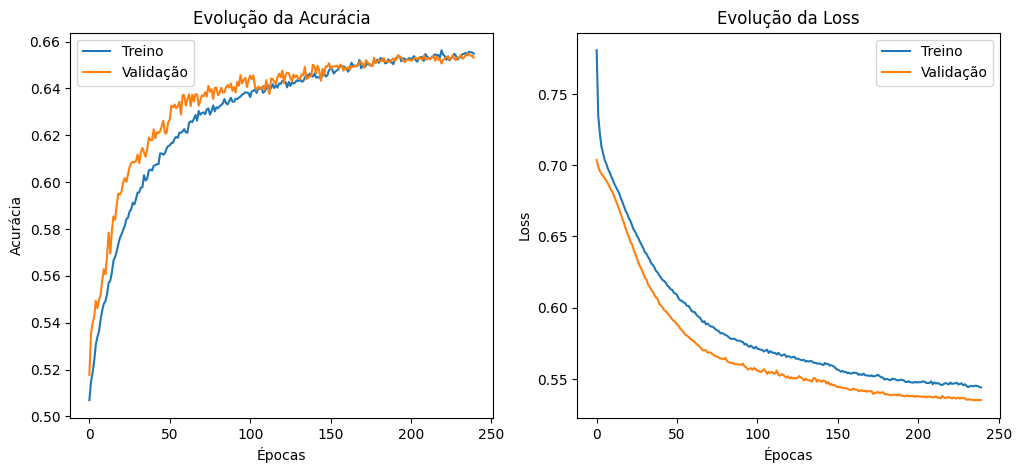

In [90]:
# 📈 Plotar evolução da Acurácia e da Loss
plt.figure(figsize=(12,5))

# Acurácia
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Evolução da Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

Tabela de avaliação do modelo

In [91]:
# Avaliar o modelo
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

1453/1453 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Acurácia: 0.6527939088914698
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.63      0.66      0.64     22304
           1       0.67      0.65      0.66     24190

    accuracy                           0.65     46494
   macro avg       0.65      0.65      0.65     46494
weighted avg       0.65      0.65      0.65     46494

